In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys


In [2]:
### Load datamodel from .p file
run_name = 'run0'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from C:\Users\Emma\Desktop\analysis\2021\02\14\run0\run0-datamodel.p


In [3]:
### Information about run:

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0.1,1,2,3]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = 5 #len(tweezer_freq_list)

mol_freq_list = [4.5,5,5.5,6,6.5,7,7.5,8]
num_frames = 10 #len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

40 points
10 frames
5 tweezers
5456 shots
136 complete loops


In [4]:
counts_array = np.zeros((num_frames,len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

for point in range(num_points):
    probe_att_counter = point % len(probe_att_list)
    pzt_para_counter = point // len(probe_att_list)
    for frame_num in range(num_frames):
        for twz_counter in range(num_tweezers):
            counts_array[frame_num,probe_att_counter,pzt_para_counter,twz_counter,:]=\
                datamodel.get_data_by_point(f'frame-{frame_num:02d}_tweezer-{twz_counter:02d}_counts',point,\
                                           shots=range(num_loops*num_points))
            
print(counts_array.shape)

(10, 4, 10, 5, 136)


In [596]:
# Calculate cav_brightness and cav_fidelity for every shot!! 

cav_brightness = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_brightness_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_avg = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
cav_fidelity_mov_sigma = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))

ref_counts = counts_array[num_frames-1,:,:,:,:]
base = np.mean(ref_counts,3)

zeropeakHWFMper = 1.5
upper_threshold = base + 1.2 * zeropeakHWFMper * roi_area

base = np.repeat(base[:,:,:,np.newaxis],num_loops,axis=3)
upper_threshold = np.repeat(upper_threshold[:,:,:,np.newaxis], num_loops, axis=3)

counts_1 = counts_array[0,:,:,:,:]


for frame_num in range(num_frames - 2):
    mol_freq = mol_freq_list[frame_num]
    counts = counts_array[frame_num,:,:,:,:]
    counts_next = counts_array[frame_num+1,:,:,:,:]
    mask = counts_next > upper_threshold
    counts_post_selected = np.where(mask, counts, np.nan)

    atomcenter = np.nanmean(counts_post_selected,3)

    brightness = counts_post_selected - ref_counts ## should this be ref_counts (per shot) or base (averaged)
    brightness_sigma = np.nanstd(brightness,3)
    brightness_mean = np.nanmean(brightness,3)

    lower_threshold = atomcenter - 3 * brightness_sigma
    lower_threshold = np.repeat(lower_threshold[:,:,:,np.newaxis], num_loops, axis=3)

    mask = np.greater(counts_post_selected, lower_threshold, where=~np.isnan(counts_post_selected))
    counts_postpost_selected = np.where(mask, counts_post_selected, np.nan)
    
    atomcenter = np.nanmean(counts_postpost_selected,3)
    brightness = counts_postpost_selected - ref_counts ## should this be ref_counts (per shot) or base (averaged)
    brightness_mean = np.nanmean(brightness,3)
    brightness_sigma = np.nanstd(brightness,3)
    
    lower_threshold = atomcenter - 3 * brightness_sigma

    cav_brightness[frame_num,:,:,:,:] = brightness # num_frames x 
    cav_fidelity[frame_num,:,:,:,:] = np.where(counts>upper_threshold,1,0)

cav_brightness_mean = np.nanmean(cav_brightness,4)
cav_brightness_sigma = np.nanstd(cav_brightness,4)
cav_fidelity_mean = np.nanmean(cav_fidelity,4)
cav_fidelity_sigma = np.sqrt(num_loops*cav_fidelity_mean*(1-cav_fidelity_mean))/(num_loops)

In [597]:
num_avg = 25 # number of loops to put in moving average

for loop in range(num_loops):
    cav_brightness_mov_avg[:,:,:,:,loop] = np.nanmean(cav_brightness[:,:,:,:,max(0,loop-num_avg//2):(loop+num_avg//2)],4)
    cav_brightness_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_brightness[:,:,:,:,max(0,loop-num_avg//2):(loop+num_avg//2)],4)
    cav_fidelity_mov_avg[:,:,:,:,loop] = np.nanmean(cav_fidelity[:,:,:,:,max(0,loop-num_avg//2):(loop+num_avg//2)],4)
    cav_fidelity_mov_sigma[:,:,:,:,loop] = np.nanstd(cav_fidelity[:,:,:,:,max(0,loop-num_avg//2):(loop+num_avg//2)],4)

C:\Users\Emma\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
C:\Users\Emma\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


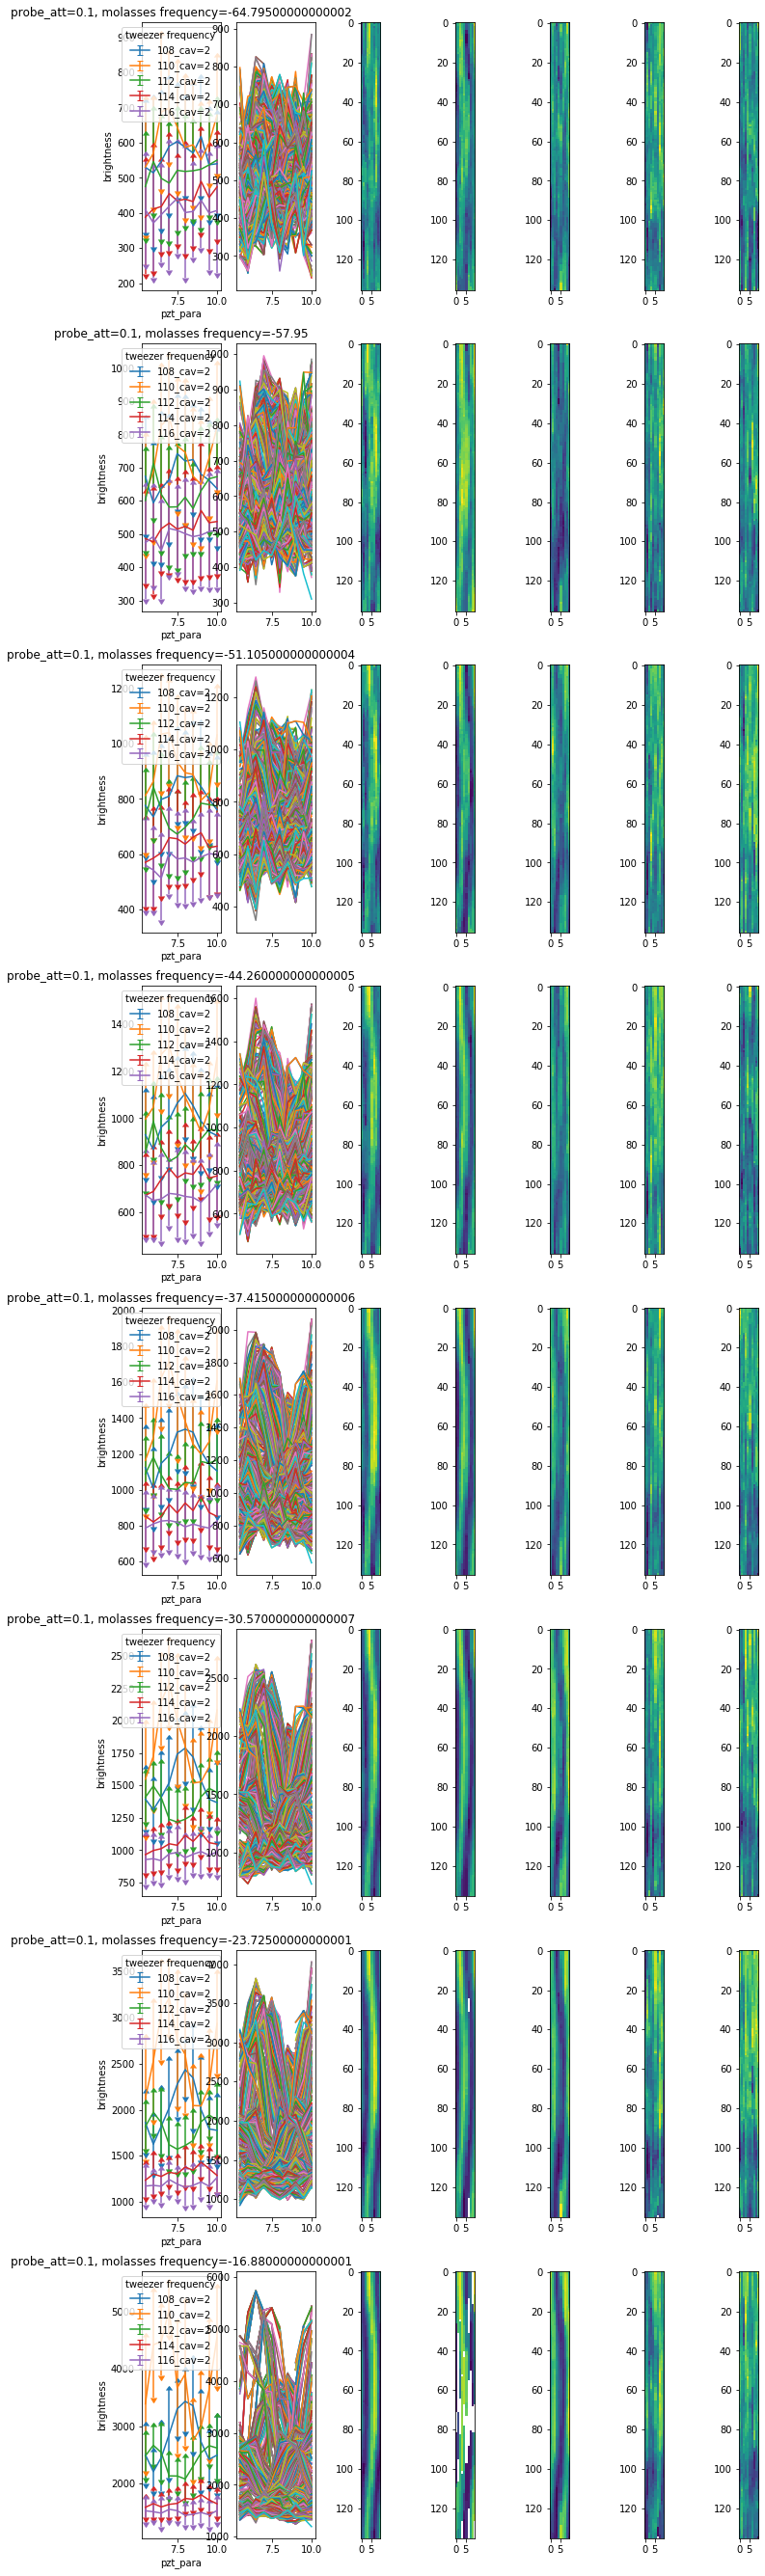

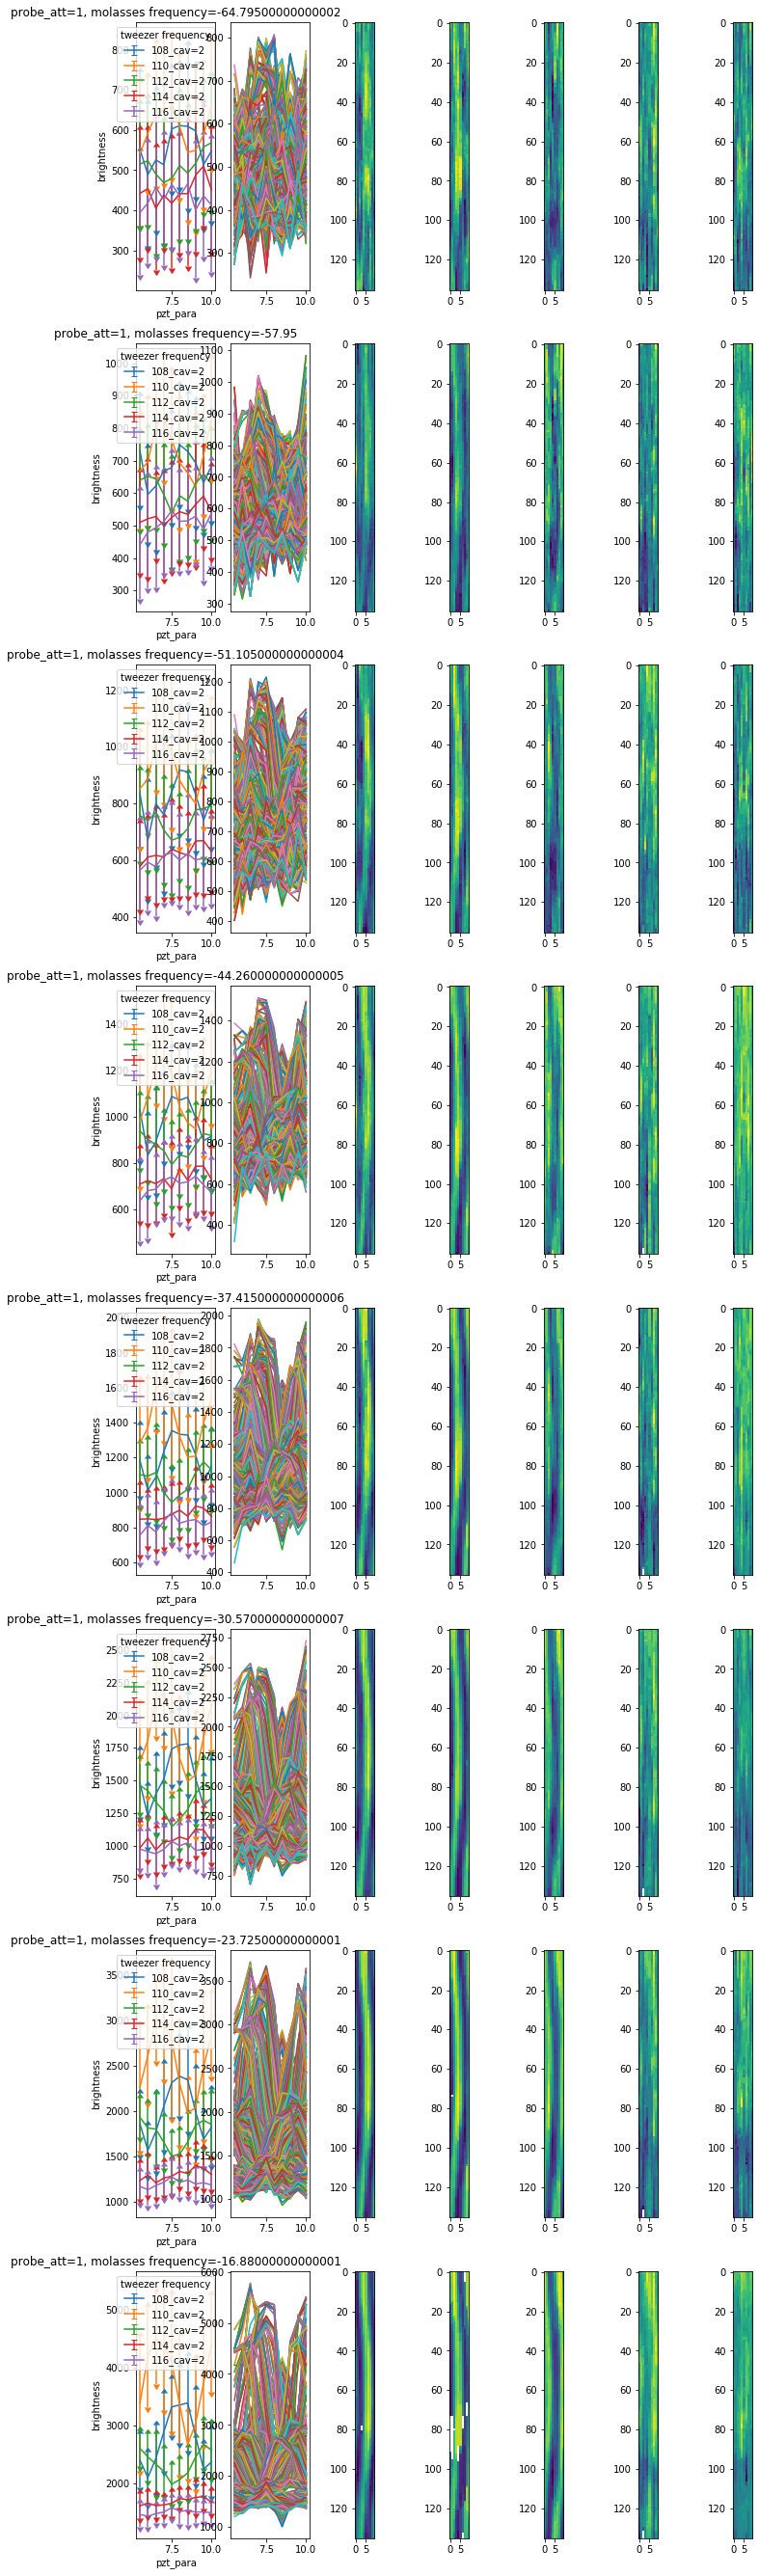

In [444]:
# PICK ONE probe_att (0.1) and molasses freq and tweezer?, plot brightness vs pzt_para
# GRID: probe_att & molasses freq (8X4=24 rows): brightness
# PLOT: brightness vs pzt_para; survival prob vs pzt_para; for all tweezers. 
num_tweezers_plot = num_tweezers

for probe_att_counter in range(2):
    fig, axs = plt.subplots(len(mol_freq_list), 2+num_tweezers_plot,  figsize=(12, len(mol_freq_list)*6))
    for mol_counter in range(len(mol_freq_list)):
        axs[mol_counter,0].set_xlabel('pzt_para')
        axs[mol_counter,0].set_ylabel('brightness')
        axs[mol_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]}, molasses frequency={mol_freq_list[mol_counter]}')        
        axs[mol_counter,0].tick_params(axis='y')
        for tweezer_counter in range(num_tweezers_plot):
            axs[mol_counter,0].errorbar(np.array(pzt_para_list), cav_brightness_mean[mol_counter, probe_att_counter, :, tweezer_counter], \
                yerr = cav_brightness_sigma[mol_counter, probe_att_counter, :, tweezer_counter],  uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}_cav=2')
            for loop in range(0,num_loops,1):
                axs[mol_counter,1].plot(np.array(pzt_para_list),cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,loop])
            axs[mol_counter,2+tweezer_counter].imshow(np.transpose(cav_brightness_mov_avg[mol_counter,probe_att_counter,:,tweezer_counter,:]))
        axs[mol_counter,0].legend(title='tweezer frequency', bbox_to_anchor=(1.05, 1), loc='upper right')
            

In [618]:
### Calculate shifted pzt paras for each mol_freq, probe_att, tweezer, loop --> 
# Likely should collapse this into one list of pzt_paras per loop!!!

shifted_pzt_paras_array = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))
brightness_mov_avg_mean_subtracted = np.zeros((len(mol_freq_list),len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list),num_loops))


def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))

for mol_freq_counter in range(len(mol_freq_list)):
    for tweezer_counter in range(num_tweezers):
        for probe_att_counter, probe_att in enumerate(probe_att_list):
            popt, pcov = curve_fit(func_cos, np.array(pzt_para_list),\
                           cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                           sigma = cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                           p0=[1000, 4000, 7, 0], maxfev = 10000)

            a0, b0, wavelength0, xshift0 = popt

            def func_cos2(x, xshift, b):
                return b + a0 * np.cos(4*np.pi/wavelength0*(x+xshift)) 

            for loop in range(num_loops):
                ba = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]
                pzt_list = np.array(pzt_para_list)[~np.isnan(ba)]
                ba_sig = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop][~np.isnan(ba)]
                ba = ba[~np.isnan(ba)]
                popt, pcov = curve_fit(func_cos2, pzt_list,\
                                       ba,\
            #                            sigma = ba_sig,\
                                       p0=[0,b0], maxfev = 10000)

                xshift = popt[0]
                avg_brightness = popt[1]

                shifted_pzt_paras_array[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop] = (np.array(pzt_para_list)+xshift-xshift0)
                brightness_mov_avg_mean_subtracted[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]=\
                        cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-avg_brightness+b0

C:\Users\Emma\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


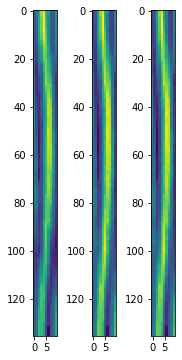

In [619]:
mol_freq_counter = 5
probe_att_counter = 0
tweezer_counter = 0
fig, axs = plt.subplots(1, 3,figsize=[3,6])
axs[0].imshow(np.transpose(cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,:]));
axs[1].imshow(np.transpose(brightness_mov_avg_mean_subtracted[mol_freq_counter,probe_att_counter,:,tweezer_counter,:]));
axs[2].imshow(np.transpose(cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,:]\
                        -np.mean(cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,:],0)));

In [620]:
### Pick a shifted_pzt_paras to use: 
shifted_pzt_paras = shifted_pzt_paras_array[5,0,:,1,:]

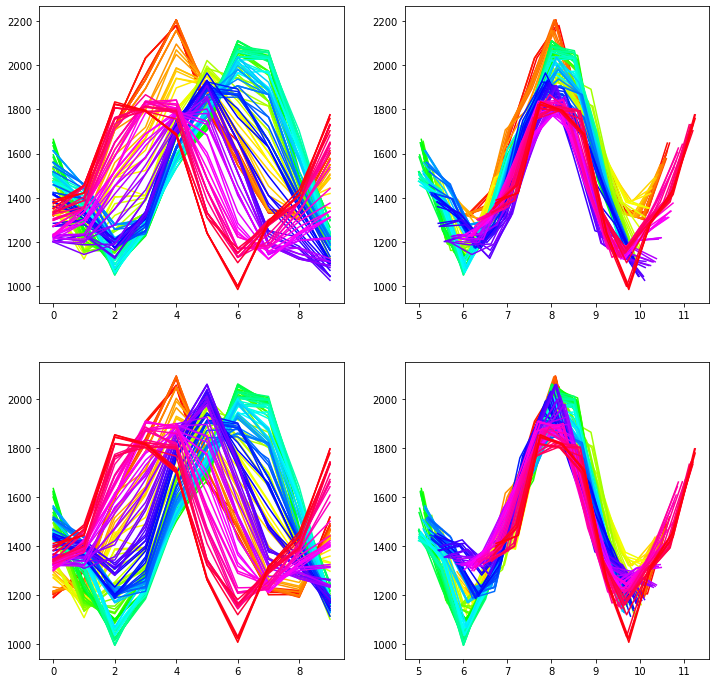

In [621]:
fig, axs = plt.subplots(2, 2,figsize=[12,12])
for loop in range(num_loops):
    color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
    axs[0,0].plot(cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],c=color)
    axs[0,1].plot(shifted_pzt_paras[:,loop],cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],c=color)
    axs[1,0].plot(brightness_mov_avg_mean_subtracted[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],c=color)
    axs[1,1].plot(shifted_pzt_paras[:,loop],brightness_mov_avg_mean_subtracted[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],c=color)

In [622]:
cav_brightness_mov_avg = brightness_mov_avg_mean_subtracted

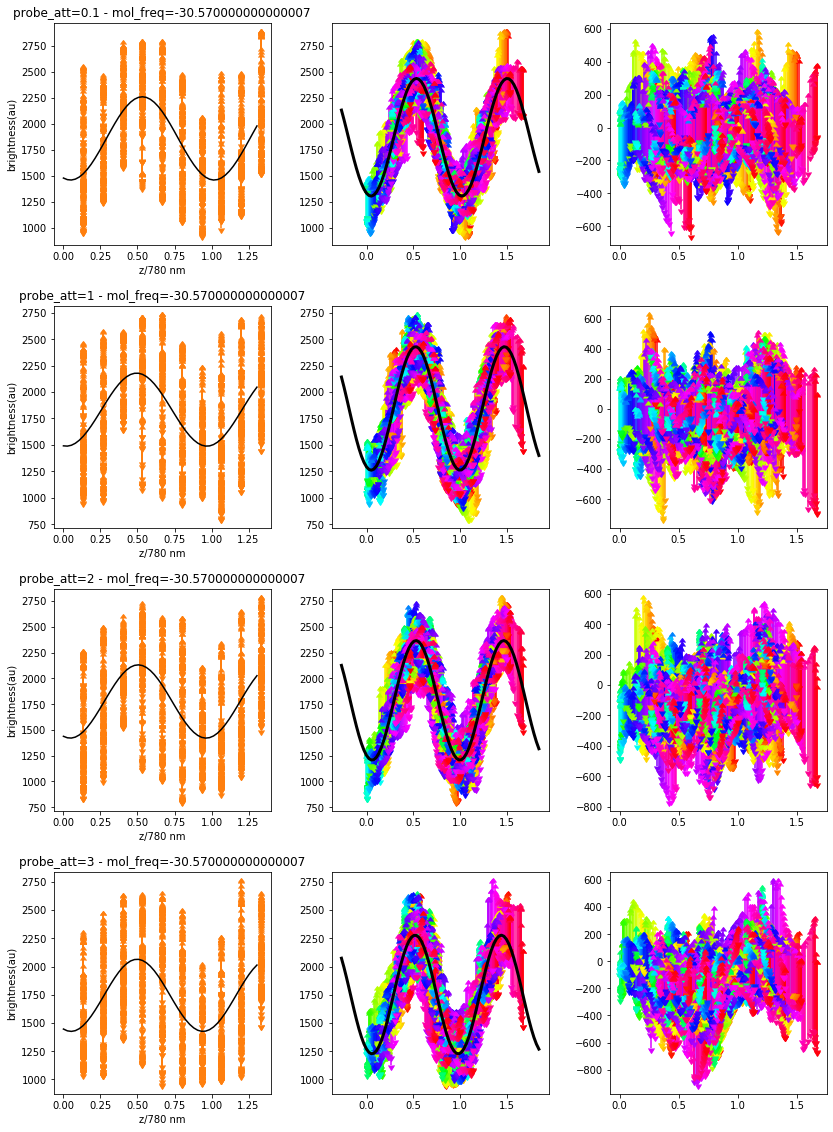

In [623]:
y_mag = 1 #13.64
x_mag = 2/7.5


mol_freq_counter = 5
tweezer_counter = 1


fig, axs = plt.subplots(len(probe_att_list), 3,  figsize=(12, 4*len(probe_att_list)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)

for probe_att_counter, probe_att in enumerate(probe_att_list):
    popt, pcov = curve_fit(func_cos, np.array(pzt_para_list),\
                   cav_brightness_mean[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                   sigma = cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter],\
                   p0=[600, 2000, 7, 3], maxfev = 10000)

    a0, b0, wavelength0, xshift0 = popt

    xx = np.arange(5,10,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)

    axs[probe_att_counter,0].plot(x_mag * (xx-5),y_mag * yy,'-', color ='black',zorder=100)

    for loop in range(num_loops):
        axs[probe_att_counter,0].errorbar(x_mag * (np.array(pzt_para_list)-5) ,\
                                         y_mag * cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                         yerr = y_mag * cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                         uplims=True, lolims=True, label= f'{tweezer_freq_list[tweezer_counter]}', ls='', color = f'C{tweezer_counter:01d}');

    axs[probe_att_counter,0].set_xlabel('z/780 nm')
    axs[probe_att_counter,0].set_ylabel('brightness(au)')
    axs[probe_att_counter,0].set_title(f'probe_att={probe_att_list[probe_att_counter]} - mol_freq={mol_freq_list[mol_freq_counter]}');
    

    shifted_pzt = shifted_pzt_paras[:,num_avg//2:num_loops - num_avg//2].flatten()
    cav_b = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
    cav_b_sigma = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()


    popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                   cav_b[~np.isnan(cav_b)],\
    #                sigma = cav_b_sigma[~np.isnan(cav_b)],\
                   p0=[1000, 4000, 7, 0], maxfev = 10000)

    a0, b0, wavelength0, xshift0 = popt
    
    if probe_att_counter==0:
        A0 = a0
        B0 = b0
        WAVELENGTH0 = wavelength0
        XSHIFT0 = xshift0
    
    xx = np.arange(min(shifted_pzt)-1,max(shifted_pzt)+1,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)

    axs[probe_att_counter,1].plot(x_mag *(xx-5),y_mag*yy,'-', color ='black',lw=3,zorder=100)
    

    for loop in range(num_loops):
        color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
        axs[probe_att_counter,1].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          y_mag*cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          yerr = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);
    
        axs[probe_att_counter,2].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          y_mag*(cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-\
                                                func_cos(shifted_pzt_paras[:,loop],A0,B0,WAVELENGTH0,XSHIFT0)),\
                                          yerr = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);

In [625]:
# using last tweezer as reference:
# averaging brightness of last tweezer over all piezo positions for each mol freq and probe att. 

# not sure whether to avg all of these or not?
# maybe should just calc one for all? if the idea is it's outside the probe mode. 

# bg_brightness = np.zeros((len(mol_freq_list), len(probe_att_list)))
# bg_brightness_sigma = np.zeros((len(mol_freq_list), len(probe_att_list)))

# for mol_counter in range(len(mol_freq_list)):
#     for probe_att_counter in range(len(probe_att_list)):
#         bg_brightness[mol_counter, probe_att_counter] = np.mean(cav_brightness_mean[mol_counter, probe_att_counter, :, -1])
#         bg_brightness_sigma[mol_counter, probe_att_counter] = np.sqrt(np.mean(cav_brightness_sigma[mol_counter, probe_att_counter, :, -1]**2) \
#                     + np.mean((cav_brightness_mean[mol_counter, probe_att_counter, :, -1]-bg_brightness[mol_counter, probe_att_counter])**2))
        
# bg_fidelity = np.zeros((len(mol_freq_list), len(probe_att_list)))
# bg_fidelity_sigma = np.zeros((len(mol_freq_list), len(probe_att_list)))

# for mol_counter in range(len(mol_freq_list)):
#     for probe_att_counter in range(len(probe_att_list)):
#         bg_fidelity[mol_counter, probe_att_counter] = np.mean(cav_fidelity_mean[mol_counter, probe_att_counter, :, -1])
#         bg_fidelity_sigma[mol_counter, probe_att_counter] = np.sqrt(np.mean(cav_fidelity_sigma[mol_counter, probe_att_counter, :, -1]**2) \
#                     + np.mean((cav_fidelity_mean[mol_counter, probe_att_counter, :, -1]-bg_fidelity[mol_counter, probe_att_counter])**2))


bg_brightness = np.mean(cav_brightness_mean[:,:,:,-1],2)
bg_brightness_sigma = np.std(cav_brightness_sigma[:,:,:,-1],2)
bg_fidelity = np.mean(cav_fidelity_mean[:,:,:,-1],2)
bg_fidelity_sigma = np.std(cav_fidelity_sigma[:,:,:,-1],2)

        
# ## Alternative: calc bg_brightness and _fidelity average over all probe att settings: 

# bg_brightness = np.zeros(len(mol_freq_list))
# bg_brightness_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_brightness[mol_counter] = np.mean(cav_brightness[mol_counter, :, :, -1])
#     bg_brightness_sigma[mol_counter] = np.sqrt(np.mean(cav_brightness_sigma[mol_counter, :, :, -1]**2) \
#                 + np.mean((cav_brightness[mol_counter, :, :, -1]-bg_brightness[mol_counter])**2))
        
# bg_fidelity = np.zeros(len(mol_freq_list))
# bg_fidelity_sigma = np.zeros(len(mol_freq_list))

# for mol_counter in range(len(mol_freq_list)):
#     bg_fidelity[mol_counter] = np.mean(cav_fidelity[mol_counter, :, :, -1])
#     bg_fidelity_sigma[mol_counter] = np.sqrt(np.mean(cav_fidelity_sigma[mol_counter, :, :, -1]**2) \
#                 + np.mean((cav_fidelity[mol_counter, :, :, -1]-bg_fidelity[mol_counter])**2))

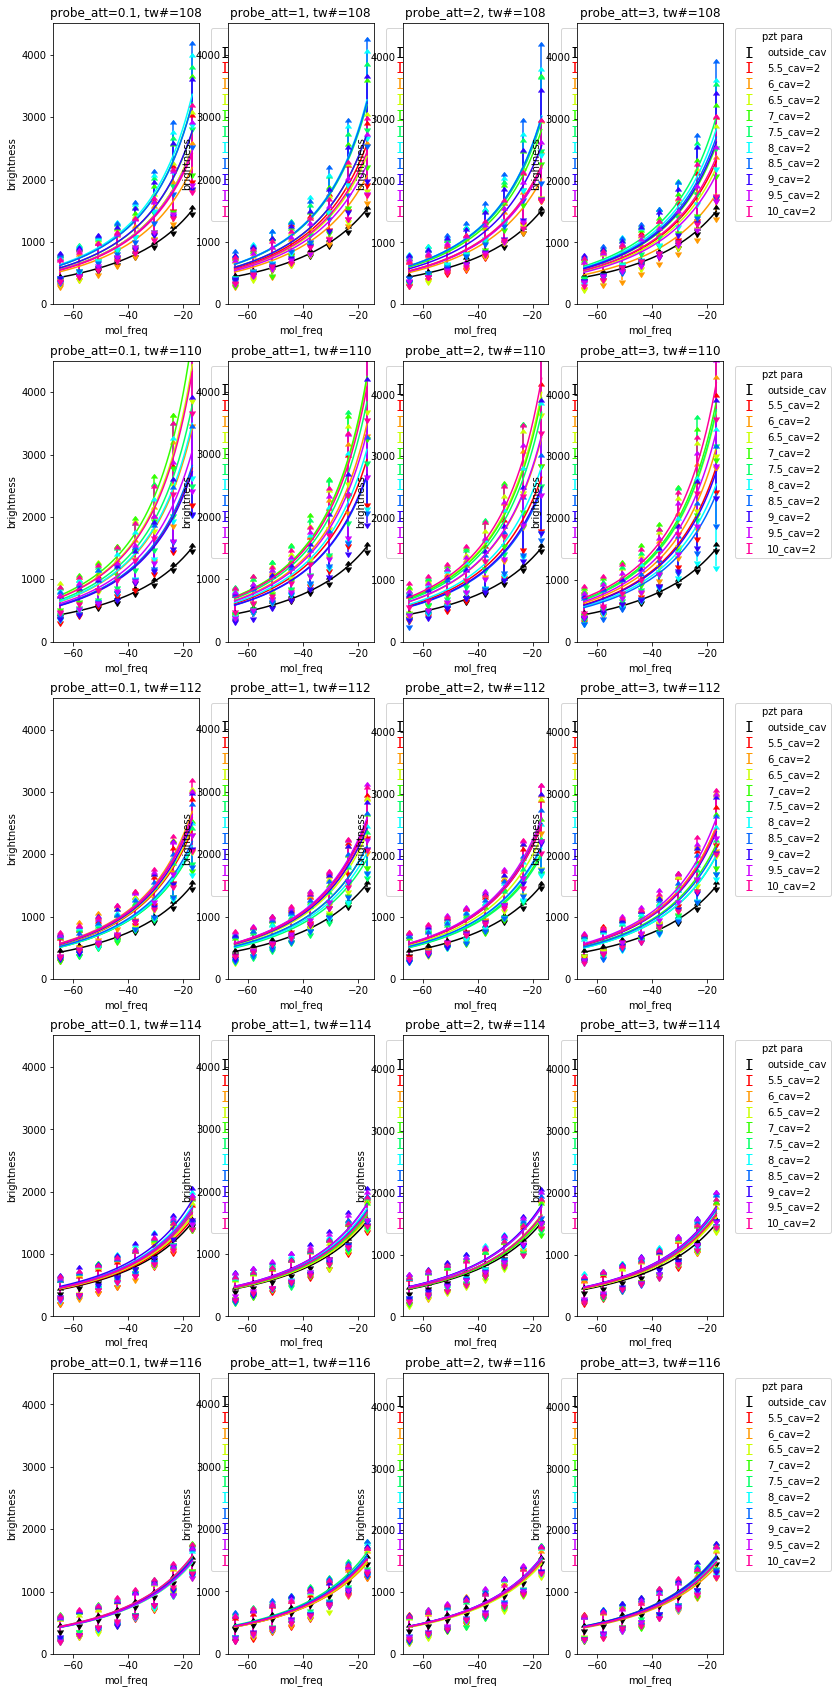

In [627]:
# For each tweezer and each probe_att, plot brightness vs mol_freq for every pzt_position. 
# GRID: tweezer X probe_att
# PLOT: brightness X mol_freq, diff pzt settings.

mol_freq_list = np.array([4.5,5,5.5,6,6.5,7,7.5,8])*13.69 - 126.4 #molasses detuning from bare atomic resonance
# - 39


# ac_compensation = 0 #0.11


def func(x, a, center):
    return  a / (x+center)**2

starkshift = np.zeros((len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list)))
starkshift_sigma = np.zeros((len(probe_att_list),len(pzt_para_list),len(tweezer_freq_list)))
detuning_conversion_params = np.zeros((len(probe_att_list),4))

detuning_conversion_list = []
# starkshift = np.zeros((len(probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))
# starkshift_sigma = np.zeros((len( probe_att_list), len(tweezer_freq_list),len(pzt_para_list)))

fig, axs = plt.subplots(len(tweezer_freq_list), len(probe_att_list[:]),  figsize=(12, len(tweezer_freq_list)*6))

for probe_att_counter, probe_att in enumerate(probe_att_list):
    
    mask = bg_brightness[:, probe_att_counter] > 400
    popt, pcov = curve_fit(func, np.array(mol_freq_list)[mask], bg_brightness[:, probe_att_counter][mask],\
                           sigma = bg_brightness_sigma[:, probe_att_counter][mask], p0=[4.5e6, -40], maxfev = 10000)
    
    a_nocav, center_nocav = popt
    sigma_center_nocav = np.sqrt(pcov[1,1])
    sigma_a_nocav = np.sqrt(pcov[0,0])
    
    def brightness_to_stark(br,m_f):
        return -(a_nocav/br)**0.5 - m_f - center_nocav
    
    detuning_conversion_params[probe_att_counter,:] = [a_nocav, center_nocav, sigma_a_nocav, sigma_center_nocav]
    detuning_conversion_list.append(brightness_to_stark)
        
    def func2(x, center):
        return  a_nocav / (x+center_nocav+center)**2

    
    for tweezer_counter in range(len(tweezer_freq_list)):
        axs[tweezer_counter,probe_att_counter].set_xlabel('mol_freq')
        axs[tweezer_counter,probe_att_counter].set_ylabel('brightness')
        axs[tweezer_counter,probe_att_counter].set_title(f'probe_att={probe_att}, tw#={tweezer_freq_list[tweezer_counter]}')
    
        
        axs[tweezer_counter,probe_att_counter].plot(np.arange(mol_freq_list[0],mol_freq_list[-1]+0.1,0.1),func(np.arange(mol_freq_list[0],mol_freq_list[-1]+0.1,0.1), a_nocav, center_nocav), linestyle='-', c = 'black')
        axs[tweezer_counter,probe_att_counter].errorbar(np.array(mol_freq_list)[mask],  bg_brightness[:, probe_att_counter][mask],\
                                                        yerr = bg_brightness_sigma[:, probe_att_counter][mask], \
                                                        uplims=True, lolims=True, label= f'outside_cav', linestyle='', c = 'black')
        for pzt_counter in range(len(pzt_para_list)):
            
            color = colorsys.hsv_to_rgb(pzt_counter/len(pzt_para_list),1,1)
            mask = np.logical_and(np.logical_and(np.logical_and(cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter] > 300 ,\
                cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter]  < 30*max(bg_brightness[:, probe_att_counter])),\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] <2000)     ,\
                cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter] >0.1) 
            if len(np.array(mol_freq_list)[mask]) > 0:
                popt, pcov = curve_fit(func2, np.array(mol_freq_list)[mask], cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter][mask],\
                               sigma = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask], p0=[ 10.5], maxfev = 10000)
            else:
                popt = [0]
                pcov = np.zeros((1,1))
            center_cav = popt
            sigma_center_cav = np.sqrt(pcov[0,0])
            starkshift_temp = center_cav
            sigma_starkshift_temp = np.sqrt(sigma_center_nocav**2 + sigma_center_cav**2)
            starkshift[probe_att_counter, pzt_counter, tweezer_counter] = starkshift_temp
            starkshift_sigma[probe_att_counter, pzt_counter, tweezer_counter] = sigma_starkshift_temp
#             print([starkshift_temp,sigma_starkshift_temp])
    #         print(starkshift)
            axs[tweezer_counter,probe_att_counter].errorbar(np.array(mol_freq_list)[mask], cav_brightness_mean[:, probe_att_counter, pzt_counter, tweezer_counter][mask], \
            yerr = cav_brightness_sigma[:, probe_att_counter, pzt_counter, tweezer_counter][mask],  uplims=True, lolims=True, label= f'{pzt_para_list[pzt_counter]}_cav=2', linestyle='', color = color)
            axs[tweezer_counter,probe_att_counter].plot(np.arange(mol_freq_list[0],mol_freq_list[-1]+0.1,0.1),func2(np.arange(mol_freq_list[0],mol_freq_list[-1]+0.1,0.1),  center_cav), linestyle='-', color = color)

            axs[tweezer_counter,probe_att_counter].set_ylim([0, 3*np.amax(bg_brightness[:, probe_att_counter])])

        axs[tweezer_counter,probe_att_counter].legend(title='pzt para', bbox_to_anchor=(1.05, 1), loc='upper left')
        axs[tweezer_counter,probe_att_counter].tick_params(axis='y')

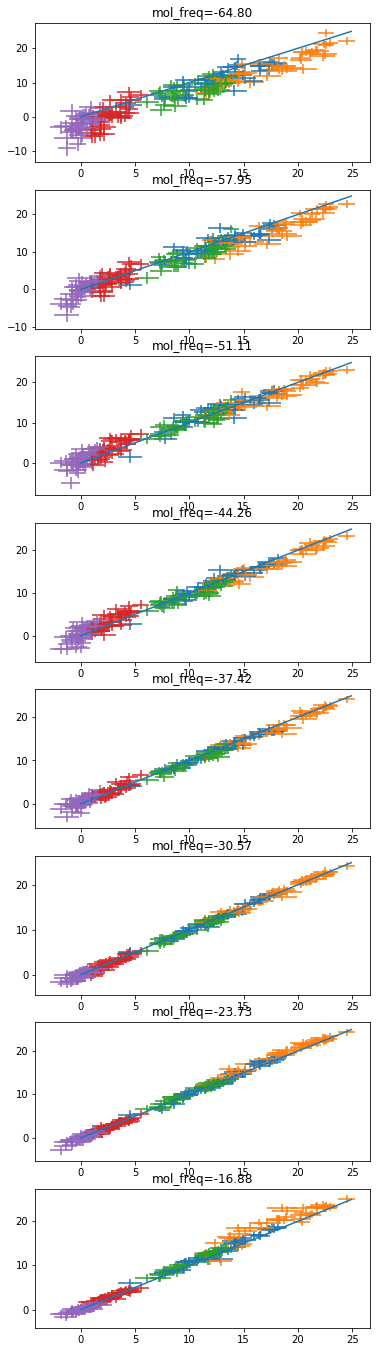

In [628]:
plt.figure(figsize=[6,24])

for mol_freq_counter in range(len(mol_freq_list)):
    plt.subplot(len(mol_freq_list),1,mol_freq_counter+1)
    plt.title(f'mol_freq={mol_freq_list[mol_freq_counter]:.02f}')

    for probe_att_counter in range(len(probe_att_list)):
    
        for twz_counter in range(num_tweezers):
            a = detuning_conversion_params[probe_att_counter,0]
            d = detuning_conversion_params[probe_att_counter,1]
            a_sig = detuning_conversion_params[probe_att_counter,2]
            d_sig = detuning_conversion_params[probe_att_counter,3]
            b = cav_brightness_mean[mol_freq_counter,probe_att_counter,:,twz_counter]
            b_sig = cav_brightness_sigma[mol_freq_counter,probe_att_counter,:,twz_counter]
            m = mol_freq_list[mol_freq_counter]
            starkshift_constfreq = -(a/b)**0.5 - m - d
            starkshift_cf_sig = (a_sig/(4*a*b)+a*b_sig/(4*b**3)+d_sig)**0.5
            plt.errorbar(starkshift[probe_att_counter,:,twz_counter],\
                         starkshift_constfreq,\
                         xerr=starkshift_sigma[probe_att_counter,:,twz_counter],\
                         yerr=starkshift_cf_sig,\
#                          uplims=True, lolims=True, \
#                          xlolims=True,xuplims=True,\
                         linestyle='',c=f'C{twz_counter}')

    plt.plot(np.arange(0,25,0.1),np.arange(0,25,0.1))

In [629]:
starkshift_mov_avg = np.zeros_like(cav_brightness_mov_avg)
starkshift_mov_sigma = np.zeros_like(starkshift_mov_avg)

# cav_brightness_mov_avg = cav_brightness_mov_avg\
#                   -(np.mean(cav_brightness_mov_avg,2))[:,:,np.newaxis,:,:]\
#                   +(np.mean(cav_brightness_mov_avg,(2,4))[:,:,np.newaxis,:,np.newaxis])

for mol_freq_counter in range(len(mol_freq_list)):
    for probe_att_counter in range(len(probe_att_list)):
        a = detuning_conversion_params[probe_att_counter,0]
        d = detuning_conversion_params[probe_att_counter,1]
        a_sig = detuning_conversion_params[probe_att_counter,2]
        d_sig = detuning_conversion_params[probe_att_counter,3]
        m = mol_freq_list[mol_freq_counter]
        b = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,:,:]
        b_sig = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,:,:]
        starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,:,:] = - (a/b)**0.5 - m - d
        starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,:,:] = (a_sig/(4*a*b)+a*b_sig/(4*b**3)+d_sig)**0.5

C:\Users\Emma\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


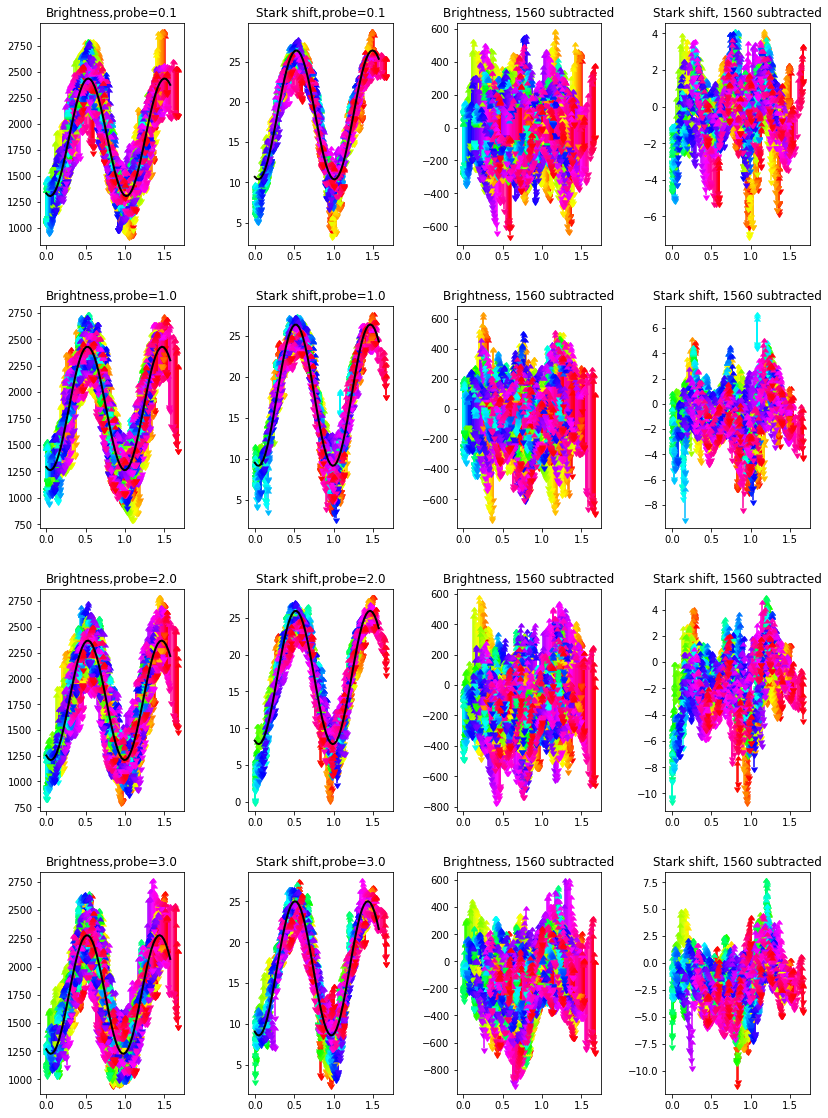

In [631]:
x_mag = 2/7.5


mol_freq_counter = 5
tweezer_counter = 1


fig, axs = plt.subplots(len(probe_att_list), 4,  figsize=(12, 4*len(probe_att_list)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))
    
for probe_att_counter, probe_att in enumerate(probe_att_list):
    
    shifted_pzt = shifted_pzt_paras[:,num_avg//2:num_loops - num_avg//2].flatten()
    cav_b = cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
    cav_b_sigma = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()

    popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(cav_b)],\
                   cav_b[~np.isnan(cav_b)],\
    #                sigma = cav_b_sigma[~np.isnan(cav_b)],\
                   p0=[1000, 4000, 7, 0], maxfev = 10000)
    a0, b0, wavelength0, xshift0 = popt
    if probe_att_counter==0:
        A0 = a0
        B0 = b0
        WAVELENGTH0 = wavelength0
        XSHIFT0 = xshift0

    xx = np.arange(5,11,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)
    
    axs[probe_att_counter,0].plot(x_mag*(xx-5),yy,zorder=100,color='black',lw=2)
    
    stark = starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
    stark_sigma = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()

    popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(stark)],\
                   stark[~np.isnan(stark)],\
                   p0=[10, 10, 7, 0], maxfev = 10000)
    a0, b0, wavelength0, xshift0 = popt
    xx = np.arange(5,11,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)
    
    axs[probe_att_counter,1].plot(x_mag*(xx-5),yy,zorder=100,color='black',lw=2)
    
    if probe_att_counter==0:
        A00 = a0
        B00 = b0
        WAVELENGTH00 = wavelength0
        XSHIFT00 = xshift0
    
    
    for loop in range(num_loops):
        color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
        axs[probe_att_counter,0].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          yerr = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);
        
        axs[probe_att_counter,1].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          yerr = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);
     
        axs[probe_att_counter,2].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          (cav_brightness_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-\
                                                func_cos(shifted_pzt_paras[:,loop],A0,B0,WAVELENGTH0,XSHIFT0)),\
                                          yerr = cav_brightness_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);

        axs[probe_att_counter,3].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          (starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-\
                                                func_cos(shifted_pzt_paras[:,loop],A00,B00,WAVELENGTH00,XSHIFT00)),\
                                          yerr = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);

    axs[probe_att_counter,0].set_title(f'Brightness,probe={probe_att_list[probe_att_counter]:.01f}')
    axs[probe_att_counter,1].set_title(f'Stark shift,probe={probe_att_list[probe_att_counter]:.01f}')
    axs[probe_att_counter,2].set_title(f'Brightness, 1560 subtracted')
    axs[probe_att_counter,3].set_title(f'Stark shift, 1560 subtracted')

In [634]:
np.zeros_like(x_mag)

array(0.)

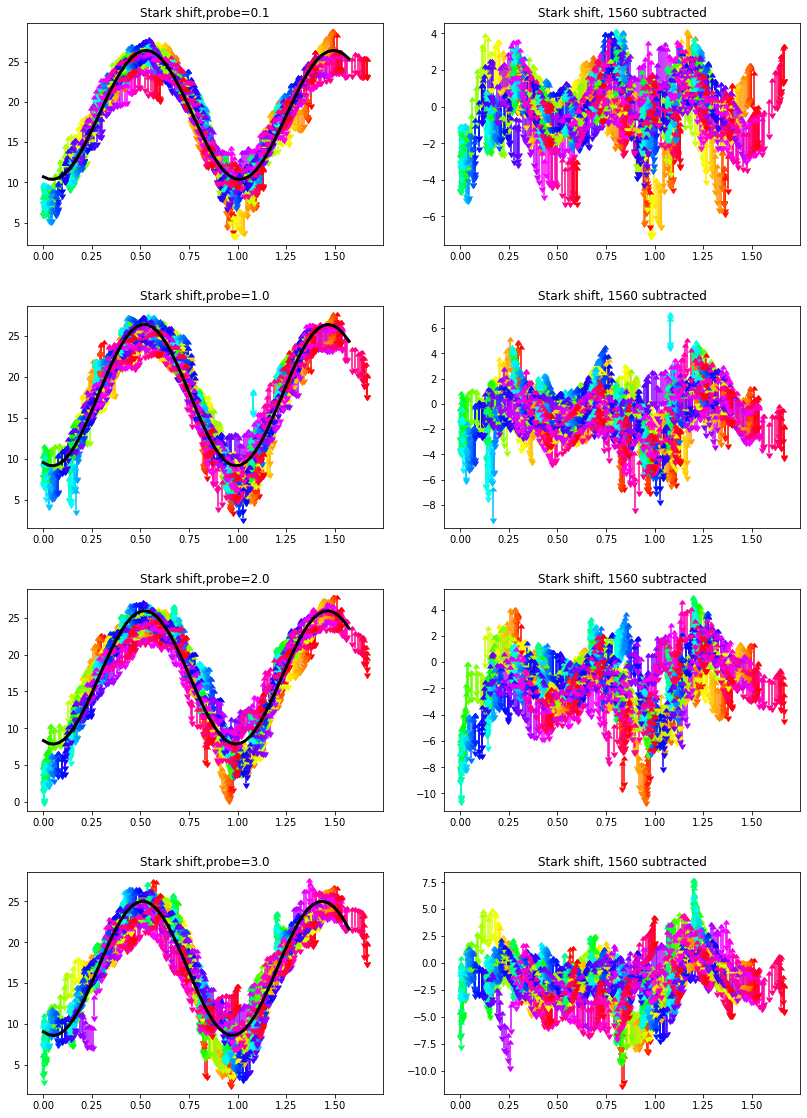

In [635]:
x_mag = 2/7.5


mol_freq_counter = 5
tweezer_counter = 1

probeshift_mov_avg = np.zeros_like(starkshift_mov_avg)


fig, axs = plt.subplots(len(probe_att_list), 2,  figsize=(12, 4*len(probe_att_list)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))
    
for probe_att_counter, probe_att in enumerate(probe_att_list):
    
    shifted_pzt = shifted_pzt_paras[:,num_avg//2:num_loops - num_avg//2].flatten()
    stark = starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
    stark_sigma = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()

    popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(stark)],\
                   stark[~np.isnan(stark)],\
                   p0=[10, 10, 7, 0], maxfev = 10000)
    a0, b0, wavelength0, xshift0 = popt
    xx = np.arange(5,11,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)
    
    axs[probe_att_counter,0].plot(x_mag*(xx-5),yy,zorder=100,lw=3,c='black')
    
    if probe_att_counter==0:
        A00 = a0
        B00 = b0
        WAVELENGTH00 = wavelength0
        XSHIFT00 = xshift0
    
#     axs[probe_att_counter,0].errorbar(x_mag*(shifted_pzt-5),\
#                                       stark,\
#                                       yerr = stark_sigma,\
#                                       uplims=True, lolims=True, ls = '');
        
#     axs[probe_att_counter,1].errorbar(x_mag*(shifted_pzt-5),\
#                                       stark-func_cos(shifted_pzt,A00,B00,WAVELENGTH00,XSHIFT00),\
#                                       yerr = stark_sigma,\
#                                       uplims=True, lolims=True, ls = '');
    for loop in range(num_loops):
        color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
        axs[probe_att_counter,0].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          yerr = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);
        
        axs[probe_att_counter,1].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          (starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop]-\
                                                func_cos(shifted_pzt_paras[:,loop],A00,B00,WAVELENGTH00,XSHIFT00)),\
                                          yerr = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);
    probeshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,:] = \
            starkshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,:] -\
            func_cos(shifted_pzt_paras,A00,B00,WAVELENGTH00,XSHIFT00)
    axs[probe_att_counter,0].set_title(f'Stark shift,probe={probe_att_list[probe_att_counter]:.01f}')
    axs[probe_att_counter,1].set_title(f'Stark shift, 1560 subtracted')

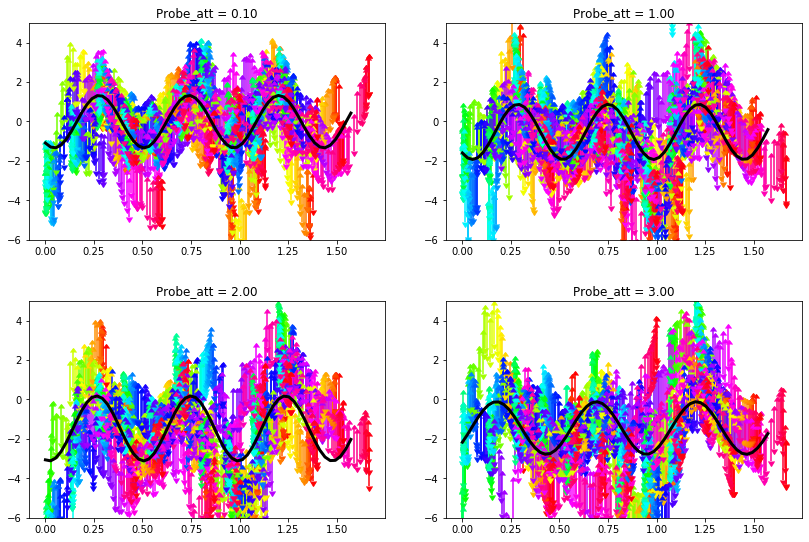

In [662]:
x_mag = 2/7.5

mol_freq_counter = 5
tweezer_counter = 1

fig, axs = plt.subplots(2, 2,  figsize=(12, 2*len(probe_att_list)))
fig.tight_layout(pad=3, w_pad=3, h_pad=4.0)

def func_cos(x, a, b, wavelength, xshift):
    return b + a * np.cos(4*np.pi/wavelength*(x+xshift))
    
for probe_att_counter, probe_att in enumerate(probe_att_list):
    
    shifted_pzt = shifted_pzt_paras[:,num_avg//2:num_loops - num_avg//2].flatten()
    probeshift = probeshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,num_avg//2:num_loops - num_avg//2].flatten()
 
    popt, pcov = curve_fit(func_cos, shifted_pzt[~np.isnan(probeshift)],\
                   probeshift[~np.isnan(probeshift)],\
                   p0=[2, 0, 3.5, 0], maxfev = 10000)
    a0, b0, wavelength0, xshift0 = popt
    xx = np.arange(5,11,0.1)
    yy = func_cos(xx,a0,b0,wavelength0,xshift0)
    
    axs[probe_att_counter//2,probe_att_counter%2].plot(x_mag*(xx-5),yy,zorder=100,lw=3,c='black')
    
    for loop in range(num_loops):
        color = colorsys.hsv_to_rgb(loop/num_loops,1,1)
        axs[probe_att_counter//2,probe_att_counter%2].errorbar(x_mag*(shifted_pzt_paras[:,loop]-5),\
                                          probeshift_mov_avg[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          yerr = starkshift_mov_sigma[mol_freq_counter,probe_att_counter,:,tweezer_counter,loop],\
                                          uplims=True, lolims=True, ls = '', color = color);
    axs[probe_att_counter//2,probe_att_counter%2].set_title(f'Probe_att = {probe_att:.02f}')
    axs[probe_att_counter//2,probe_att_counter%2].set_ylim([-6,5])

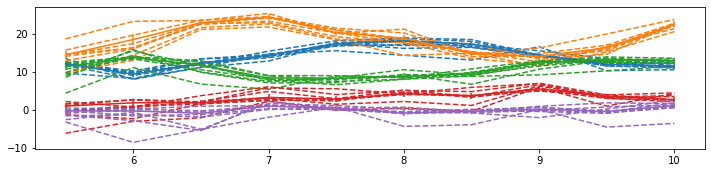

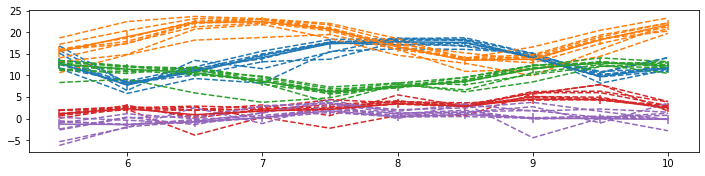

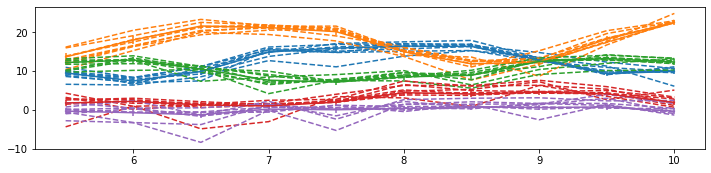

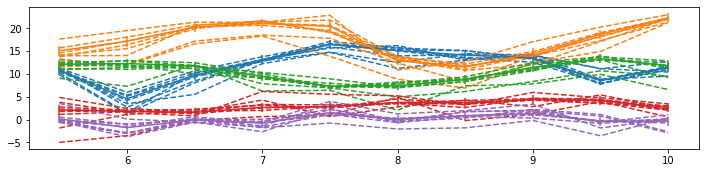

In [281]:
## Look at diff between freq-scan stark shift and const-freq stark shift
# one plot for each probe_att; plotting each tweezer's AC stark shift.
# solid line is from full-freq-scan, dashed is from const-freq scan. 

for probe_att_counter in range(len(probe_att_list)):
    plt.figure(figsize=[12,12])
    plt.subplot(len(probe_att_list),1,probe_att_counter+1)
    for twz_counter in range(num_tweezers):
        plt.errorbar(pzt_para_list,starkshift[probe_att_counter,:,twz_counter],yerr=starkshift_sigma[probe_att_counter,:,twz_counter])
        for mol_freq_counter in range(len(mol_freq_list)):
            plt.plot(pzt_para_list,detuning_conversion_list[probe_att_counter](cav_brightness_mean[mol_freq_counter,probe_att_counter,:,twz_counter],mol_freq_list[mol_freq_counter])\
                                     ,c=f'C{twz_counter}',ls='dashed')
#     plt.plot(detuning_conversion_list[2](cav_brightness_mean[6,2,:,twz_counter])+mol_freq_list[6],c=f'C{twz_counter}',ls='dashed')
#     plt.plot(detuning_conversion_list[2](cav_brightness_mean[7,2,:,twz_counter])+mol_freq_list[7],c=f'C{twz_counter}',ls='dotted')